In [1]:
from fmdtools.sim.approach import SampleApproach, NominalApproach
import fmdtools.analyze as an
import fmdtools.sim.propagate as prop
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['pdf.fonttype'] = 42
import multiprocessing as mp
import scipy.stats as stats


import multiprocessing as mp

In [2]:
from rover_model_human import *
from rover_model import plot_trajectories, plot_map

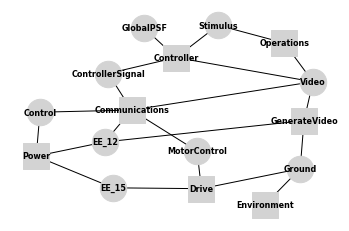

In [3]:
mdl = Rover()
fig, ax = an.graph.show(mdl, gtype='bipartite')

(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot:title={'center':'Execution Order'}>)

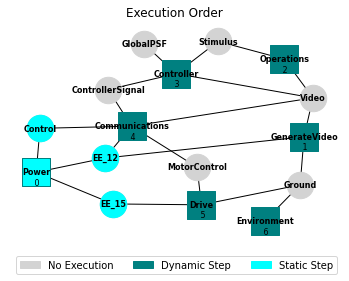

In [4]:
an.graph.exec_order(mdl, gtype='bipartite')

In [5]:
act_pos={'Press': [0.942, 0.076], 'ComprehendOut': [0.302, 0.452], 'SeeOut': [0.028, 0.732], 
             'Project': [0.499, 0.46], 'PressOut': [0.958, -0.07], 'Reach': [0.797, 0.175], 
             'ProjectOut': [0.482, 0.302], 'ReachOut': [0.806, 0.041], 'Comprehend': [0.317, 0.595], 
             'Look': [0.038, 0.877], 'Decide': [0.667, 0.308], 'DecideOut': [0.652, 0.189], 
             'Signal': [0.721, 0.736], 'Percieve': [0.165, 0.738], 'PercieveOut': [0.102, 0.594], 
             'Video': [0.418, 0.889], 'Stimulus': [0.026, 1.034], 'LocalPSF': [0.717, 0.484], 
             'GlobalPSF': [0.521, 0.836]}

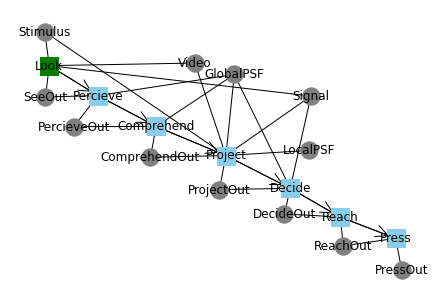

In [6]:
fig = mdl.fxns['Controller'].show_ASG(pos=act_pos, with_cond_labels=False)

In [7]:
fig.savefig("action_graph.pdf", format="pdf", bbox_inches = 'tight', pad_inches = 0)

In [8]:
mdl = Rover(params=gen_params('sine', amp=2, wavelength=30))
endresults, mdlhist = prop.nominal(mdl)
plot_map(mdl, mdlhist)

Error at t=1 in scenario {'sequence': {}, 'properties': {'time': 0.0, 'rate': 1.0, 'type': 'nominal'}}


Exception: LastPowerswitchState changed type: <class 'numpy.bool_'> to <class 'int'> at t_ind=1

In [ ]:
app_human = SampleApproach(mdl, faults='Controller', phases={'start':[0,50]})

In [ ]:
app_human.sampletimes

In [ ]:
endclasses,mdlhists = prop.approach(mdl, app_human)

In [ ]:
comp_groups={'faulty': [i[0] for i in app_human.scenids.values()],'nominal': ['nominal']}

In [ ]:
fig, axs = an.plot.mdlhists(mdlhists, comp_groups=comp_groups, fxnflowvals={'Ground':['vel', 'x','y'], 'Power':'power'}, time_slice=[14],\
                           title="Rover Response to Human Fault Modes at t=14", indiv_kwargs={'faulty':{'alpha':0.5, 'color':'red'}},
                           ylabels={('flows','Ground','x'):'meters',('flows','Ground','y'):'meters', ('flows', 'Ground', 'vel'):'m/s',
                                   ('functions', 'Power', 'power'): 'Volts'}, xlabel='time (s)',
                            titles={('flows','Ground','x'):'x position',('flows','Ground','y'):'y position', ('flows', 'Ground', 'vel'):'velocity',
                                   ('functions', 'Power', 'power'): 'throttle'}, h_padding=0.3)

In [ ]:
fig.savefig("rover_fault_behavior.pdf", format="pdf", bbox_inches = 'tight', pad_inches = 0)

In [ ]:
def stress_param_func(stress_param=1.0, experience=1.0):
    return {'stress_param': stress_param, 'experience': experience}

In [ ]:
nomapp_human_short = NominalApproach()
#nomapp_human_short.add_seed_replicates('test', 25)
nomapp_human_short.add_param_ranges(stress_param_func, 'test', experience=(1.0,5,1), replicates=10)

In [ ]:
deg_mdl_hum_short = HumanDegradationShort(params={'experience' : 1, 'stress_param': 0,'stoch_fatigue':True})
endclasses_human_short, mdlhists_human_short = prop.nominal_approach(deg_mdl_hum_short, nomapp_human_short, run_stochastic=True)

In [ ]:
fig, axs = an.plot.mdlhists(mdlhists_human_short, fxnflowvals={"Control":['fatigue','stress']}, aggregation='mean_bound', xlabel="time (hours)",
                           ylabels={('functions', 'Control', 'fatigue'):'level',('functions','Control','stress'):'level (%)'}, h_padding=0.3,
                           titles={('functions', 'Control', 'fatigue'):'fatigue',('functions','Control','stress'):'stress'})

In [ ]:
fig.savefig("degraded_PSFs.pdf", format="pdf", bbox_inches = 'tight', pad_inches = 0)

In [ ]:
nomapp_human_short.num_scenarios

In [ ]:
behave_nomapp = NominalApproach()
behave_nomapp.add_param_ranges(sample_human_params, 'behave_nomapp', mdlhists_human_short, t=(0,10, 1), scen = (0,nomapp_human_short.num_scenarios))

In [ ]:
mdl=Rover(params=gen_params('sine', amp=2, wavelength=30))
behave_endclasses_hum, behave_mdlhists_hum = prop.nominal_approach(mdl, behave_nomapp, run_stochastic=True)

In [ ]:
fig = an.plot.nominal_vals_2d(behave_nomapp, behave_endclasses_hum, 't', 'scen', xlabel='single-day time (hours)', ylabel='scenario',  metric='at_finish', title="Nominal Mission Completed?")

In [ ]:
fig.savefig("nominal_PSF_completions.pdf", format="pdf", bbox_inches = 'tight', pad_inches = 0)

In [ ]:
app_drive= SampleApproach(mdl, faults='Operations', phases={'start':[0,50]})

In [ ]:
endclasses,mdlhists = prop.approach(mdl, app_drive)

In [ ]:
app_human_nest = NominalApproach()
app_human_nest.add_param_ranges(sample_human_params, 'Communications', mdlhists_human_short, t=(4,9, 4), scen = (0,nomapp_human_short.num_scenarios))

In [ ]:
endclasses,mdlhists,apps = prop.nested_approach(mdl, app_human_nest, faults='Communications', phases={'start':[0,50]})

In [ ]:
res_comp_hum = an.tabulate.resilience_factor_comparison(app_human_nest, endclasses, ['t'], 'at_finish', faults='modes')
res_comp_hum

In [ ]:
fig = an.plot.resilience_factor_comparison(res_comp_hum, stack=True, maxy=1.1, xlabel='time (workday)', figsize=(10,4), title="", stat="proportion complete")  

In [ ]:
endclasses,mdlhists, apps = prop.nested_approach(mdl, app_human_nest, faults='Operations', phases={'start':[0,1]})

In [ ]:
mdlhists['Communications_1']['Operations no_con, t=0']['functions']['Operations']

In [ ]:
mdlhists['Communications_1']['Operations no_con, t=0']['flows']['Control']

In [ ]:
apps

In [ ]:
res_comp_hum = an.tabulate.resilience_factor_comparison(app_human_nest, endclasses, ['t'], 'at_finish', faults='modes')
res_comp_hum

In [ ]:
fig = an.plot.resilience_factor_comparison(res_comp_hum, stack=True, maxy=1.1, xlabel='time (workday)', figsize=(10,4), title="", stat="proportion complete")  